# Twitter data preprocessing using `lib` 

## Setup

In [1]:
import sys
sys.path.append("../")

import os

In [2]:
%load_ext autoreload
%autoreload 2

In [62]:
from lib.utils import get_files
from lib.enums import BACKUP

from lib.preprocessing.utils import clean_data 
from lib.preprocessing.tweets import clean_tweet 
from lib.preprocessing.text import (
    tokenize, 
    remove_punctuation, 
    remove_stopwords, 
    stem
)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pemma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pemma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [103]:
import pandas as pd
import numpy as np 
import pickle as pkl 

## Load datasets & merge

In [5]:
tweets_dir = f"../{BACKUP}"
files = get_files(tweets_dir)
files

['../backup/tweets/cheap_2020-01-01_2020-12-31.csv',
 '../backup/tweets/cheap_2021-01-01_2021-12-31.csv',
 '../backup/tweets/cheap_2022-01-01_2022-12-31.csv',
 '../backup/tweets/econ_terms_2020-01-01_2020-12-31.csv',
 '../backup/tweets/econ_terms_2021-01-01_2021-12-31.csv',
 '../backup/tweets/econ_terms_2022-01-01_2022-12-31.csv',
 '../backup/tweets/english_2020-01-01_2020-12-31.csv',
 '../backup/tweets/english_2021-01-01_2021-12-31.csv',
 '../backup/tweets/english_2022-01-01_2022-12-31.csv',
 '../backup/tweets/expensive_2020-01-01_2020-12-31.csv',
 '../backup/tweets/expensive_2021-01-01_2021-12-31.csv',
 '../backup/tweets/expensive_2022-01-01_2022-12-31.csv',
 '../backup/tweets/institutions_2020-01-01_2020-12-31.csv',
 '../backup/tweets/institutions_2021-01-01_2021-12-31.csv',
 '../backup/tweets/institutions_2022-01-01_2022-12-31.csv',
 '../backup/tweets/prices_2020-01-01_2020-12-31.csv',
 '../backup/tweets/prices_2021-01-01_2021-12-31.csv',
 '../backup/tweets/prices_2022-01-01_2022-1

In [6]:
df = pd.DataFrame()
for f in files: 
    tmp = pd.read_csv(f)
    df = pd.concat([df, tmp])

In [7]:
n_tweets, n_features = df.shape

print(f"{n_tweets} tweets with {n_features} features")

92961 tweets with 11 features


In [8]:
df.head()

,UserScreenName,UserName,Timestamp,Text,Embedded_text,Emojis,Comments,Likes,Retweets,Image link,Tweet URL
0,christian champagnat,@fandki,2020-01-01T09:45:23.000Z,christian champagnat\n@fandki\n·\n1 Jan 2020,le tout vendu à des prix \n«défiant toute conc...,NaN,NaN,NaN,NaN,[],https://twitter.com/fandki/status/121230883031...
1,Rached Guettouche,@RgGeutt,2020-01-01T20:00:47.000Z,Rached Guettouche\n@RgGeutt\n·\n1 Jan 2020,Pour ceux qui veulent allier l'utile à l'agréa...,🛑 🛑,NaN,NaN,NaN,['https://pbs.twimg.com/media/ENOJSzoX0AA8uYz?...,https://twitter.com/RgGeutt/status/12124636996...
2,fidele kabambi,@kabambi_fidele,2020-01-02T07:21:19.000Z,fidele kabambi\n@kabambi_fidele\n·\n2 Jan 2020,"Nouvelle perspective: BARAKA BUSINESS SARL, ne...",NaN,NaN,NaN,3.0,['https://pbs.twimg.com/media/ENQlDGvXUAAxpIh?...,https://twitter.com/kabambi_fidele/status/1212...
3,Marcus Antonius Rex,@ghjattu_neru,2020-01-02T09:41:43.000Z,Marcus Antonius Rex\n@ghjattu_neru\n·\n2 Jan 2020,J'ai du mal à savoir si #Cirelli a reçu la Leg...,NaN,NaN,1.0,3.0,[],https://twitter.com/ghjattu_neru/status/121267...
4,Free au Sénégal,@free_senegal,2020-01-06T17:40:53.000Z,Free au Sénégal\n@free_senegal\n·\n6 Jan 2020,Un iPhone pas cher ? C’est maintenant possible...,⭐ 😉,36.0,69.0,284.0,['https://pbs.twimg.com/media/ENnZOz9XYAEOun2?...,https://twitter.com/free_senegal/status/121424...


## Clean dataset

In [9]:
# remove duplicates just in case

df = df.drop_duplicates()

n_tweets = df.shape[0]
print(f"{n_tweets} after duplicates removal")

92857 after duplicates removal


In [41]:
df_cleaned = clean_data(df)

## Quick exploration

In [12]:
n_users = np.unique(df.username.values).shape[0]
print(f"{n_users} unique users")

43911 unique users


In [13]:
# users with more tweets between 2020 and 2022

df.groupby("username").\
    size().\
    sort_values(ascending=False).\
    head(10)

username
@ezints            384
@BFMTV             290
@lemondefr         287
@HerveHannoun      215
@LesEchos          205
@libe              202
@le_Parisien       201
@DailyFXFrance     197
@BusinessBourse    182
@Le_Figaro         175
dtype: int64

In [14]:
nan_prop = df_cleaned.isna().sum() / n_tweets
print(nan_prop)

timestamp      0.000000
text           0.000000
emojis         0.634879
retweets       0.163951
likes          0.247520
comments       0.436456
text_emojis    0.634879
dtype: float64


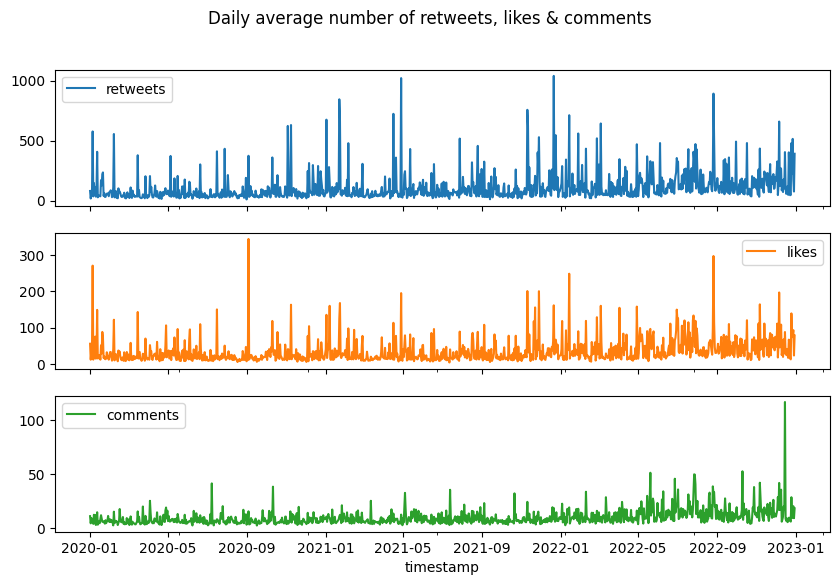

In [15]:
by = [df_cleaned.timestamp.dt.date]
num_cols = ["retweets", "likes", "comments"]

df_cleaned.groupby(by).\
    mean(num_cols).\
    plot(subplots=True, figsize=(10, 6), title="Daily average number of retweets, likes & comments"); 

## Text preprocessing on tweets

### Remove tweets' attributes

Attributes: statistics, dates, links, mentions, etc.

In [45]:
df_cleaned["text"] = df_cleaned["text"].apply(clean_tweet, remove_mentions=False)

path = "../backup/data/df_cleaned.csv"
df_cleaned.to_csv(path, index=False)

In [16]:
tweets = df_cleaned["text"].values.tolist()

In [17]:
tweets_cleaned = [clean_tweet(tweet) for tweet in tweets]

In [18]:
ix = np.random.randint(low=0, high=n_tweets)

print(f"Before cleaning:\n{tweets[ix]}")
print(f"\n\nAfter cleaning:\n{tweets_cleaned[ix]}")

Before cleaning:
Le nouveau navire de desserte de l’île d’Yeu en construction en Bretagne | Mer et Marine ⁦
@PIRIOU_Group
⁩ ⁦
@DepVendee
⁩ ⁦
@IPC_Concarneau
⁩  https://meretmarine.com/fr/content/le-nouveau-navire-de-desserte-de-lile-dile-dyeu-en-construction-en-bretagne…
2


After cleaning:
Le nouveau navire de desserte de l’île d’Yeu en construction en Bretagne | Mer et Marine ⁦ ⁩ ⁦ ⁩ ⁦ ⁩  


### In-depth preprocessing

1. Tokenization 

In [65]:
tweets_tokenized = [tokenize(tweet) for tweet in tweets_cleaned]

In [66]:
ix = np.random.randint(low=0, high=n_tweets)

print(f"Original tweet:\n{tweets[ix]}")
print(f"\n\nAfter tokenization:\n{tweets_tokenized[ix]}")

Original tweet:
Maj de mon portefeuille, nouvelles positions prises et quelques rappels importants sur l'inflation.
L'inflation et moi et moi | Quelles actions acheter en bourse trading 11 juin 2021
graphseobourse.fr
Inflation et moi et moi | Quelles actions acheter en bourse trading 11 juin 2021
L'inflation continue d'être au centre des attentions et des débats. Tout le monde a raison et ort sur les scénarios car l'important c'est l'horizon de temps que l'on prend en compte. Question de...
7
2
22


After tokenization:
['maj', 'de', 'mon', 'portefeuille', ',', 'nouvelles', 'positions', 'prises', 'et', 'quelques', 'rappels', 'importants', 'sur', 'l', "'", 'inflation', '.', 'l', "'", 'inflation', 'et', 'moi', 'et', 'moi', '|', 'quelles', 'actions', 'acheter', 'en', 'bourse', 'trading', '11', 'juin', '2021', 'inflation', 'et', 'moi', 'et', 'moi', '|', 'quelles', 'actions', 'acheter', 'en', 'bourse', 'trading', '11', 'juin', '2021', 'l', "'", 'inflation', 'continue', 'd', "'", 'être', 'au'

2. Remove punctuation 

In [67]:
tweets_no_punc = [remove_punctuation(tokens) for tokens in tweets_tokenized]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pemma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pemma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [68]:
ix = np.random.randint(low=0, high=n_tweets)

print(f"Original tweet:\n{tweets[ix]}")
print(f"\n\nAfter removing punctuation:\n{tweets_no_punc[ix]}")

Original tweet:
Quand la promotion du respect de la vie choque.
Anne Hidalgo
@Anne_Hidalgo
·
2 Jan 2020
Je suis profondément choquée et indignée par cette campagne anti-IVG et anti-PMA à la Gare du Nord et dans plusieurs autres lieux de la capitale. Je demande à @ExterionMediaFR et #Mediatransports que ces affiches soient retirées immédiatement.
3
42
43


After removing punctuation:
['quand', 'la', 'promotion', 'du', 'respect', 'de', 'la', 'vie', 'choque', 'anne', 'hidalgo', '2', 'jan', '2020', 'je', 'suis', 'profondément', 'choquée', 'et', 'indignée', 'par', 'cette', 'campagne', 'anti', 'ivg', 'et', 'anti', 'pma', 'à', 'la', 'gare', 'du', 'nord', 'et', 'dans', 'plusieurs', 'autres', 'lieux', 'de', 'la', 'capitale', 'je', 'demande', 'à', 'et', 'mediatransports', 'que', 'ces', 'affiches', 'soient', 'retirées', 'immédiatement']


3. Remove stopwords 

In [69]:
tweets_no_stopwords = [remove_stopwords(tokens) for tokens in tweets_no_punc]

In [70]:
ix = np.random.randint(low=0, high=n_tweets)

print(f"Original tweet:\n{tweets[ix]}")
print(f"\n\nAfter removing stopwords:\n{tweets_no_stopwords[ix]}")

Original tweet:
En pleine catastrophe naturelle à Goma, voici la seule urgence  de 
@NoelKTshiani
 ! Même si le ridicule ne tue pas; allez vendre vos friperies en catimini chez vos employeurs calmement. Le vrai adversaire du béton en 2023 sera son bilan et non 
@moise_katumbi
 .
4
4
24


After removing stopwords:
['pleine', 'catastrophe', 'naturelle', 'goma', 'urgence', 'ridicule', 'tue', 'pas', 'allez', 'vendre', 'friperies', 'catimini', 'employeurs', 'calmement', 'vrai', 'adversaire', 'béton', '2023', 'bilan', 'non']


4. Stemming 

In [71]:
tweets_stemmed = [stem(tweet) for tweet in tweets_no_stopwords]

In [72]:
ix = np.random.randint(low=0, high=n_tweets)

print(f"Original tweet:\n{tweets[ix]}")
print(f"\n\nAfter removing stemming:\n{tweets_stemmed[ix]}")

Original tweet:
Inflation : la Confédération nationale du logement demande au gouvernement le blocage des loyers

https://francetvinfo.fr/economie/immobilier/prix-immobilier/inflation-la-confederation-nationale-du-logement-demande-au-gouvernement-le-blocage-des-loyers_5136805.html…
4
18
28


After removing stemming:
['inflat', 'confédérat', 'national', 'logement', 'demand', 'gouvern', 'blocag', 'loyer']


## Save results

In [105]:
dates = np.datetime_as_string(df_cleaned.timestamp.values, unit="D").tolist()

tweets_preprocessed = {
    "dates": dates, 
    "original": tweets, 
    "cleaned": tweets_cleaned, 
    "tokenized": tweets_tokenized, 
    "no_punc": tweets_no_punc,
    "stemmed": tweets_stemmed
}

path = "../backup/data/tweets_preprocessed.pkl"
with open(path, "wb") as f: 
    pkl.dump(tweets_preprocessed, f)

In [101]:
with open(path, "rb") as f: 
    d = pkl.load(f)